cmc from assignment_03

# 1) FACE DETECTION

In [60]:
import os
print(os.getcwd())

/Users/tilen/school/sb/assignment_04


dict_keys(['cmc_lbp', 'cmc_hog', 'cmc_dsift', 'cmc_lbp_vj', 'cmc_hog_vj', 'cmc_dsift_vj'])
170


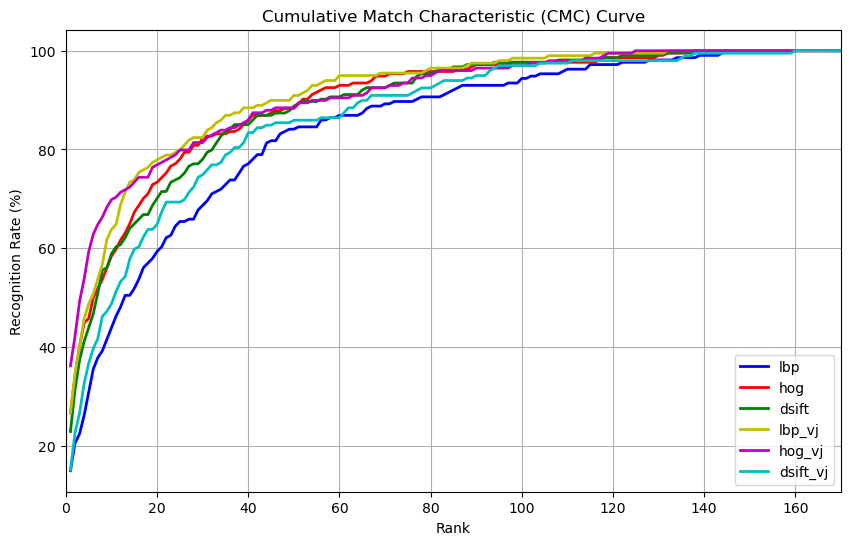

In [61]:
import pickle
import matplotlib.pyplot as plt

def plot_cmc(cmc, label="LBP", color='b-', new_figure=True):
    if new_figure:
        plt.figure(figsize=(10, 6))
        plt.grid(True)
        plt.xlabel('Rank')
        plt.ylabel('Recognition Rate (%)')
        plt.title("Cumulative Match Characteristic (CMC) Curve")
        plt.xlim(0, len(cmc))
    
    # Plot the CMC curve
    plt.plot(range(1, len(cmc)+ 1), cmc * 100, color, linewidth=2, label=label)
    plt.legend()

with open("cmc_data_170.pkl", "rb") as f:
    cmc_data = pickle.load(f)

print(cmc_data.keys())
print(len(cmc_data[list(cmc_data.keys())[0]]))

#plot each cmc curve on same plot
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Rank')
plt.ylabel('Recognition Rate (%)')
plt.title("Cumulative Match Characteristic (CMC) Curve")
plt.xlim(0, 170)

colors = ['b-', 'r-', 'g-', 'y-', 'm-', 'c-']
for key, color in zip(cmc_data.keys(), colors):
    plot_cmc(cmc_data[key], label=key[4:], color=color, new_figure=False)

plt.show()

In [62]:
import pandas as pd

# read csv
df = pd.read_csv("/Users/tilen/school/sb/assignment_04/data/CelebA-HQ-small_cleaned.csv")

df.head()

,idx,identity,x_1,y_1,width,height,split
0,112,114,243,196,548,779,train
1,123,138,271,215,540,712,test
2,145,114,315,195,528,748,train
3,181,85,221,165,556,763,train
4,209,27,274,216,500,690,train


In [63]:
print(f"test: {len(df[df['split'] == 'test'])}")
print(f"train: {len(df[df['split'] == 'train'])}")

test: 395
train: 461


In [64]:
# split the training data the same way as in previous assignment
dataset_path = "/Users/tilen/school/sb/assignment_03/data/CelebA-HQ-small"

train_data = df[df['split'] == 'train'].copy()  # Make a copy
gallery_indices_train = []
probe_indices_train = []

# Reset index to make sure we're working with clean indices
train_data = train_data.reset_index(drop=True)

for identity in train_data['identity'].unique():
    # Get all images for this identity
    identity_df = train_data[train_data['identity'] == identity]
    
    # Split images for this identity
    n_gallery = len(identity_df) // 2
    gallery_indices_train.extend(identity_df.index[:n_gallery])
    probe_indices_train.extend(identity_df.index[n_gallery:])

# Create paths and get IDs
gallery_paths_train = [os.path.join(dataset_path, f"{train_data.loc[idx, 'idx']}.jpg") for idx in gallery_indices_train]
probe_paths_train = [os.path.join(dataset_path, f"{train_data.loc[idx, 'idx']}.jpg") for idx in probe_indices_train]
gallery_ids_train = train_data.loc[gallery_indices_train, 'identity'].values
probe_ids_train = train_data.loc[probe_indices_train, 'identity'].values


In [65]:
# test set
test_data = df[df['split'] == 'test'].copy()  # Make a copy
gallery_indices_test = []
probe_indices_test = []

# Reset index to make sure we're working with clean indices
test_data = test_data.reset_index(drop=True)

# After splitting
for identity in test_data['identity'].unique():
    # Get all images for this identity
    identity_df = test_data[test_data['identity'] == identity]
    
    # Split images for this identity
    n_gallery = len(identity_df) // 2
    gallery_indices_test.extend(identity_df.index[:n_gallery])
    probe_indices_test.extend(identity_df.index[n_gallery:])

# Create paths and get IDs
gallery_paths_test = [os.path.join(dataset_path, f"{test_data.loc[idx, 'idx']}.jpg") for idx in gallery_indices_test]
probe_paths_test = [os.path.join(dataset_path, f"{test_data.loc[idx, 'idx']}.jpg") for idx in probe_indices_test]
gallery_ids_test = test_data.loc[gallery_indices_test, 'identity'].values
probe_ids_test = test_data.loc[probe_indices_test, 'identity'].values

print(len(gallery_paths_test))
print(len(probe_paths_test))
print(len(gallery_ids_test))
print(len(probe_ids_test))


181
214
181
214


In [66]:
from ultralytics import YOLO

# Load a pretrained YOLO model for face detection
model = YOLO('./deep-face-detection/yolov8n-face.pt')  # First load the base model

In [67]:
def detect_faces_yolo(image_path):
    results = model(image_path)[0]  # Get first (and only) result
    
    # Extract boxes
    boxes = []
    if len(results.boxes) > 0:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # get box coordinates
            # Convert to x, y, width, height format (like your ground truth)
            width = x2 - x1
            height = y2 - y1
            boxes.append({
                'x_1': int(x1),
                'y_1': int(y1),
                'width': int(width),
                'height': int(height),
                'confidence': float(box.conf[0])
            })
    return boxes

def calculate_iou(pred_box, gt_box):
    # Convert to x1,y1,x2,y2 format
    pred_x2 = pred_box['x_1'] + pred_box['width']
    pred_y2 = pred_box['y_1'] + pred_box['height']
    gt_x2 = gt_box['x_1'] + gt_box['width']
    gt_y2 = gt_box['y_1'] + gt_box['height']
    
    # Calculate intersection
    x1 = max(pred_box['x_1'], gt_box['x_1'])
    y1 = max(pred_box['y_1'], gt_box['y_1'])
    x2 = min(pred_x2, gt_x2)
    y2 = min(pred_y2, gt_y2)
    
    if x2 < x1 or y2 < y1:
        return 0.0
        
    intersection = (x2 - x1) * (y2 - y1)
    
    # Calculate areas
    pred_area = pred_box['width'] * pred_box['height']
    gt_area = gt_box['width'] * gt_box['height']
    
    # Calculate IoU
    union = pred_area + gt_area - intersection
    return intersection / union


image 1/1 /Users/tilen/school/sb/assignment_03/data/CelebA-HQ-small/3350.jpg: 640x640 1 face, 38.4ms
Speed: 1.4ms preprocess, 38.4ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)
Found 1 faces in test image


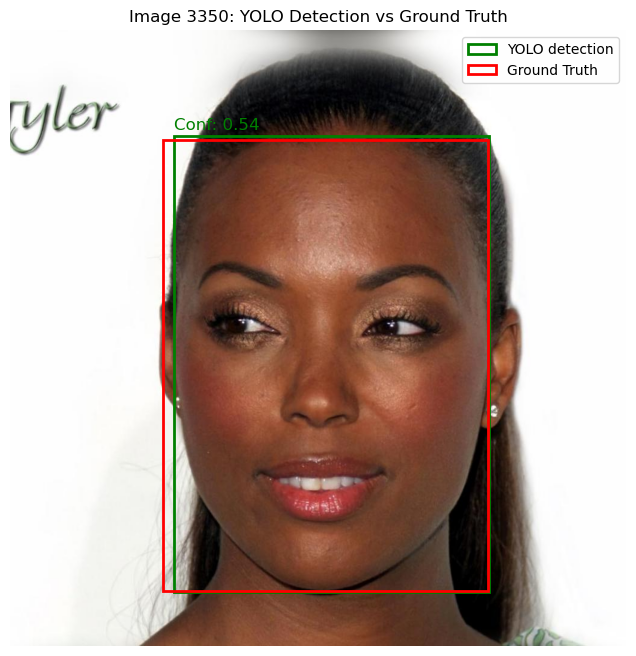

IoU score: 0.952


In [68]:
import cv2
import matplotlib.pyplot as plt

# Test on first image
test_image = probe_paths_test[0]
detections = detect_faces_yolo(test_image)
print(f"Found {len(detections)} faces in test image")

# Get ground truth for this image
image_id = int(os.path.basename(test_image).split('.')[0])
gt = df[df['idx'] == image_id].iloc[0]

# Read the image
image = cv2.imread(test_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create figure and axis
plt.figure(figsize=(12, 8))
plt.imshow(image)

# Draw YOLO detections in green
for detection in detections:
    x1 = int(detection['x_1'])
    y1 = int(detection['y_1'])
    width = int(detection['width'])
    height = int(detection['height'])
    
    # Create rectangle patch for detection
    plt.gca().add_patch(plt.Rectangle((x1, y1), width, height,
                                    fill=False, color='g', linewidth=2,
                                    label='YOLO detection'))
    
    # Add confidence score
    if 'confidence' in detection:
        plt.text(x1, y1-10, f"Conf: {detection['confidence']:.2f}", 
                color='g', fontsize=12)

# Draw ground truth in red
plt.gca().add_patch(plt.Rectangle((gt['x_1'], gt['y_1']), 
                                gt['width'], gt['height'],
                                fill=False, color='r', linewidth=2,
                                label='Ground Truth'))

plt.title(f'Image {image_id}: YOLO Detection vs Ground Truth')
plt.legend()
plt.axis('off')
plt.show()

# Calculate and print IoU
if detections:
    iou = calculate_iou(detections[0], gt)
    print(f"IoU score: {iou:.3f}")

In [69]:
def evaluate_detector(detector_func, test_paths, ground_truth_df, confidence_threshold=0.5):
    """
    Evaluate a face detector across the test set
    
    Parameters:
    - detector_func: function that takes image path and returns list of detections
    - test_paths: list of paths to test images
    - ground_truth_df: DataFrame containing ground truth annotations
    
    Returns:
    - Dictionary containing:
        - individual IoU scores
        - mean IoU
        - number of detections
        - number of missed detections
    """
    iou_scores = []
    n_detections = 0
    n_missed = 0
    
    for image_path in test_paths:
        # Get image ID from path
        image_id = int(os.path.basename(image_path).split('.')[0])
        
        # Get ground truth
        gt = ground_truth_df[ground_truth_df['idx'] == image_id].iloc[0]
        gt_box = {
            'x_1': gt['x_1'],
            'y_1': gt['y_1'],
            'width': gt['width'],
            'height': gt['height']
        }
        
        # Get detection
        detections = detector_func(image_path)

        # Filter detections by confidence threshold
        confident_detections = [d for d in detections if d.get('confidence', 0) >= confidence_threshold]
        
        if confident_detections:
            # If multiple detections, take the one with highest confidence
            best_detection = max(confident_detections, key=lambda x: x.get('confidence', 0))
            iou = calculate_iou(best_detection, gt_box)
            iou_scores.append(iou)
            n_detections += 1
        else:
            iou_scores.append(0)  # Count as 0 IoU if no face detected
            n_missed += 1
    
    results = {
        'iou_scores': iou_scores,
        'mean_iou': sum(iou_scores) / len(iou_scores),
        'n_detections': n_detections,
        'n_missed': n_missed,
        'detection_rate': n_detections / len(test_paths)
    }
    
    return results

In [70]:
# Get all test paths
test_paths = [os.path.join(dataset_path, f"{row['idx']}.jpg") 
              for _, row in df[df['split'] == 'test'].iterrows()]

# Use it for YOLO:
yolo_results = evaluate_detector(
    detector_func=detect_faces_yolo,
    test_paths=test_paths,
    ground_truth_df=df,
    confidence_threshold=0.5
)

# Print results
print(f"YOLO Detection Results:")
print(f"Mean IoU: {yolo_results['mean_iou']:.3f}")
print(f"Detection Rate: {yolo_results['detection_rate']*100:.1f}%")
print(f"Missed Detections: {yolo_results['n_missed']}/{len(test_paths)}")


image 1/1 /Users/tilen/school/sb/assignment_03/data/CelebA-HQ-small/123.jpg: 640x640 1 face, 41.1ms
Speed: 1.3ms preprocess, 41.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/tilen/school/sb/assignment_03/data/CelebA-HQ-small/285.jpg: 640x640 1 face, 41.9ms
Speed: 1.4ms preprocess, 41.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/tilen/school/sb/assignment_03/data/CelebA-HQ-small/305.jpg: 640x640 1 face, 30.7ms
Speed: 1.4ms preprocess, 30.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/tilen/school/sb/assignment_03/data/CelebA-HQ-small/562.jpg: 640x640 1 face, 26.6ms
Speed: 1.2ms preprocess, 26.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/tilen/school/sb/assignment_03/data/CelebA-HQ-small/667.jpg: 640x640 1 face, 31.2ms
Speed: 1.2ms preprocess, 31.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1

In [71]:
def detect_faces_insightface(image_path):
    # Read image
    img = cv2.imread(image_path)
    
    padding = 200  # Store padding size as variable for easy adjustment
    
    # Add padding to the image
    img_padded = cv2.copyMakeBorder(img, padding, padding, padding, padding, 
                                   cv2.BORDER_CONSTANT, value=(0, 0, 0))
    
    # Detect faces on padded image
    faces = face_analyzer.get(img_padded)
    
    # Convert to same format as YOLO for consistency
    boxes = []
    for face in faces:
        bbox = face.bbox.astype(int)
        x1, y1, x2, y2 = bbox
        
        # Subtract padding from coordinates to get position in original image
        x1 = x1 - padding
        y1 = y1 - padding
        x2 = x2 - padding
        y2 = y2 - padding
        
        # Skip if the face is completely outside the original image
        if x2 < 0 or y2 < 0 or x1 >= img.shape[1] or y1 >= img.shape[0]:
            continue
        
        # Clip coordinates to image boundaries
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(img.shape[1], x2)
        y2 = min(img.shape[0], y2)
        
        width = x2 - x1
        height = y2 - y1
        
        boxes.append({
            'x_1': int(x1),
            'y_1': int(y1),
            'width': int(width),
            'height': int(height),
            'confidence': float(face.det_score)
        })
    return boxes

import cv2
import matplotlib.pyplot as plt
from insightface.app import FaceAnalysis

# Initialize Insightface
face_analyzer = FaceAnalysis(name='buffalo_l')
face_analyzer.prepare(ctx_id=-1)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tilen/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tilen/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tilen/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0


/Users/tilen/miniconda3/envs/naloga4/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tilen/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tilen/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


/Users/tilen/miniconda3/envs/naloga4/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


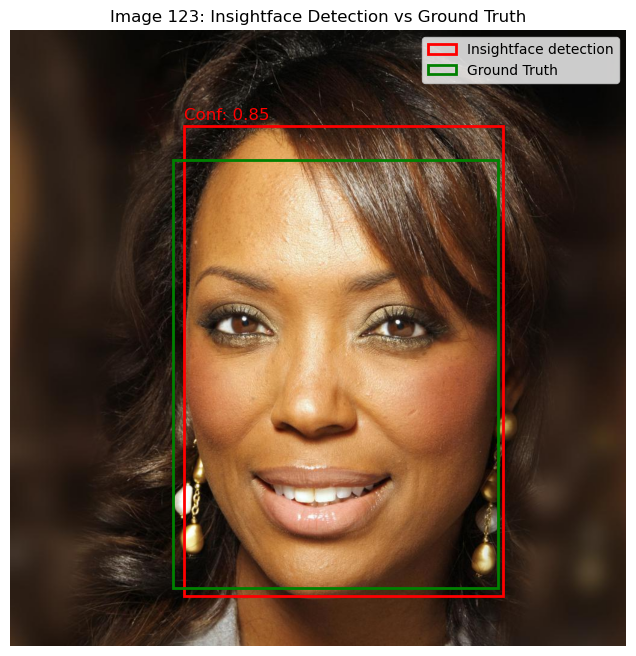

IoU score: 0.872


In [72]:
# Test on first image
test_image = test_paths[0]
detections = detect_faces_insightface(test_image)

# Get ground truth for this image
image_id = int(os.path.basename(test_image).split('.')[0])
gt = df[df['idx'] == image_id].iloc[0]

# Read and display image
img = cv2.imread(test_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(img)

# Draw Insightface detections in red
for detection in detections:
    x1 = detection['x_1']
    y1 = detection['y_1']
    width = detection['width']
    height = detection['height']
    
    plt.gca().add_patch(plt.Rectangle((x1, y1), width, height,
                                    fill=False, color='r', linewidth=2,
                                    label='Insightface detection'))
    plt.text(x1, y1-10, f"Conf: {detection['confidence']:.2f}", 
            color='r', fontsize=12)

# Draw ground truth in green
plt.gca().add_patch(plt.Rectangle((gt['x_1'], gt['y_1']), 
                                gt['width'], gt['height'],
                                fill=False, color='g', linewidth=2,
                                label='Ground Truth'))

plt.title(f'Image {image_id}: Insightface Detection vs Ground Truth')
plt.legend()
plt.axis('off')
plt.show()

# Calculate and print IoU if there are detections
if detections:
    iou = calculate_iou(detections[0], {
        'x_1': gt['x_1'],
        'y_1': gt['y_1'],
        'width': gt['width'],
        'height': gt['height']
    })
    print(f"IoU score: {iou:.3f}")

In [73]:
# Try different confidence thresholds
insightface_results = evaluate_detector(
    detector_func=detect_faces_insightface,
    test_paths=test_paths,
    ground_truth_df=df,
)

print(f"\nResults with confidence threshold 0.5:")
print(f"Mean IoU: {insightface_results['mean_iou']:.3f}")
print(f"Detection Rate: {insightface_results['detection_rate']*100:.1f}%")
print(f"Missed Detections: {insightface_results['n_missed']}/{len(test_paths)}")


Results with confidence threshold 0.5:
Mean IoU: 0.896
Detection Rate: 100.0%
Missed Detections: 0/395


# 2) FACE RECOGNITION

# insightface

In [74]:
import torch

model = FaceAnalysis(name='buffalo_l')  # Pretrained model
model.prepare(ctx_id=-1)

def compute_embedding(image_path=None, image=None, model=None):
    if image is None:
        if image_path is None:
            raise ValueError("Either image_path or image must be provided")
        img = cv2.imread(image_path)
    else:
        img = image

    # Compute embedding using ONNX model
    with torch.no_grad():
        # shape: (512,)
        embedding = model.models['recognition'].get_feat(img).flatten()
    
    return embedding


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tilen/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tilen/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tilen/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tilen/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tilen/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

In [75]:
import torch
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from PIL import Image

# Load pretrained FaceNet model
facenet_model = InceptionResnetV1(pretrained='vggface2').eval()

# Define preprocessing (FaceNet requires normalized images)
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # FaceNet requires 160x160 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Function to extract FaceNet embeddings
def extract_facenet_embedding(image_path=None, image=None):
    if image is None:
        if image_path is None:
            raise ValueError("Either image_path or image must be provided")
        img = Image.open(image_path).convert('RGB')
    else:
        img = Image.fromarray(image).convert('RGB')
    
    img = transform(img).unsqueeze(0)  # Add batch dimension

    # Extract features
    with torch.no_grad():
        embedding = facenet_model(img)

    return embedding.squeeze().numpy()  # Convert to NumPy array

# FULL PIPELINE

# whole images

In [76]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compare_embeddings_cosine(embedding1, embedding2):
    similarity = cosine_similarity([embedding1], [embedding2])[0][0]
    return similarity

def chi_square_distance(x, y):
    """Compute chi-square distance between two vectors"""
    eps = 1e-10  # small constant to avoid division by zero
    return 0.5 * np.sum((x - y)**2 / (x + y + eps))


def calculate_cmc(gallery_features, gallery_ids, probe_features, probe_ids, max_rank=10):
    """Calculate CMC curve using chi-square distance"""
    gallery_ids = np.array(gallery_ids)
    probe_ids = np.array(probe_ids)

    # Calculate pairwise chi-square distances
    distances = np.zeros((len(probe_features), len(gallery_features)))
    for i, probe in enumerate(probe_features):
        for j, gallery in enumerate(gallery_features):
            distances[i,j] = chi_square_distance(probe, gallery)
    
    sorted_indices = np.argsort(distances, axis=1)
    
    n_probes = len(probe_ids)
    cmc = np.zeros(max_rank)
    
    print("\nFirst probe example:")
    print(f"Probe ID: {probe_ids[0]}")
    print(f"Top 5 matched gallery IDs: {gallery_ids[sorted_indices[0][:5]]}")
    print(f"Corresponding distances: {distances[0][sorted_indices[0][:5]]}")

    for i, probe_id in enumerate(probe_ids):
        gallery_rankings = gallery_ids[sorted_indices[i]]
        correct_matches = np.where(gallery_rankings == probe_id)[0]
        if len(correct_matches) > 0:
            first_match = correct_matches[0]
            cmc[first_match:] += 1
    
    cmc = cmc / n_probes
    return cmc


First probe example:
Probe ID: 138
Top 5 matched gallery IDs: [138 138 138 138 138]
Corresponding distances: [     6.0786      7.4238      8.8417      8.9894      10.292]
rank1: 0.9672897196261683
rank5: 0.9813084112149533


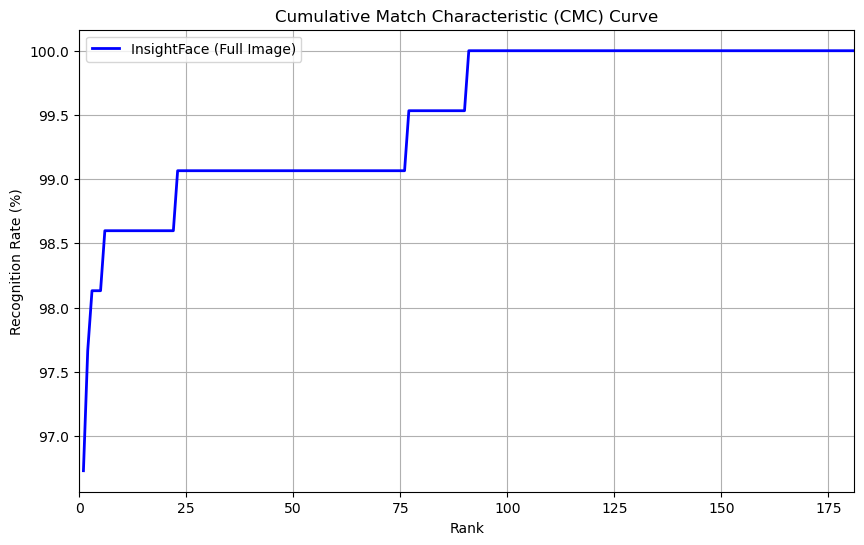

In [77]:
def normalize_features(features):
    """Normalize features to be non-negative"""
    # Method 1: Min-max scaling
    features_normalized = (features - features.min()) / (features.max() - features.min())
    return features_normalized

# Extract features for gallery and probe images using both models
gallery_features_insightface_full_img = []
probe_features_insightface_full_img = []

# Extract InsightFace features
for path in gallery_paths_test:
    embedding = compute_embedding(image_path=path, model=model)  # your existing InsightFace function
    embedding = normalize_features(embedding)
    gallery_features_insightface_full_img.append(embedding)
    
for path in probe_paths_test:
    embedding = compute_embedding(image_path=path, model=model)
    embedding = normalize_features(embedding)
    probe_features_insightface_full_img.append(embedding)

# Convert to numpy arrays
gallery_features_insightface_full_img = np.array(gallery_features_insightface_full_img)
probe_features_insightface_full_img = np.array(probe_features_insightface_full_img)

# Calculate CMC curves
max_rank = len(gallery_features_insightface_full_img)
cmc_insightface_full_img = calculate_cmc(gallery_features_insightface_full_img, gallery_ids_test, probe_features_insightface_full_img, probe_ids_test, max_rank=max_rank)

print(f"rank1: {cmc_insightface_full_img[0]}")
print(f"rank5: {cmc_insightface_full_img[4]}")

# Plot CMC curves
plot_cmc(cmc_insightface_full_img, label="InsightFace (Full Image)")
plt.show()


First probe example:
Probe ID: 138
Top 5 matched gallery IDs: [138 138 138 138 138]
Corresponding distances: [     2.0271      2.3387      2.6137      2.9151      3.7026]
rank1: 0.9252336448598131
rank5: 0.9766355140186916


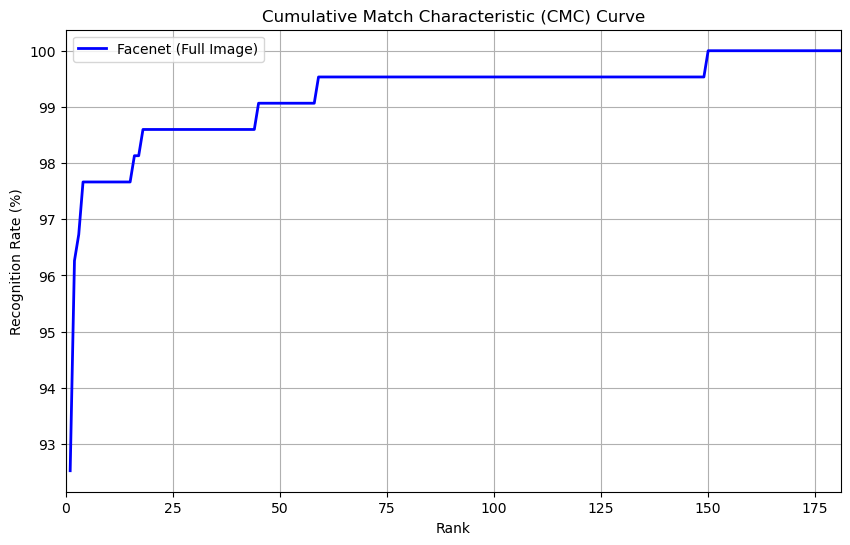

In [78]:
# Extract features for gallery and probe images using both models
gallery_features_facenet_full_img = []
probe_features_facenet_full_img = []

# Extract InsightFace features
for path in gallery_paths_test:
    embedding = extract_facenet_embedding(path)  # your existing InsightFace function
    embedding = normalize_features(embedding)
    gallery_features_facenet_full_img.append(embedding)
    
for path in probe_paths_test:
    embedding = extract_facenet_embedding(path)
    embedding = normalize_features(embedding)
    probe_features_facenet_full_img.append(embedding)

# Convert to numpy arrays
gallery_features_facenet_full_img = np.array(gallery_features_facenet_full_img)
probe_features_facenet_full_img = np.array(probe_features_facenet_full_img)

# Calculate CMC curves
max_rank = len(gallery_features_facenet_full_img)
cmc_facenet_full_img = calculate_cmc(gallery_features_facenet_full_img, gallery_ids_test, probe_features_facenet_full_img, probe_ids_test, max_rank=max_rank)

print(f"rank1: {cmc_facenet_full_img[0]}")
print(f"rank5: {cmc_facenet_full_img[4]}")

# Plot CMC curves
plot_cmc(cmc_facenet_full_img, label="Facenet (Full Image)")
plt.show()

# face detection with insightface

In [79]:
def crop_face(image_path, detected_face, target_size=(160, 160)):
    """
    Crops the detected face from an image.

    Args:
        image_path (str): Path to the image.
        detected_face (dict): Dictionary with face bounding box info (x_1, y_1, width, height).
        target_size (tuple): The size to resize the cropped face (default is 160x160 for FaceNet).

    Returns:
        face_crop_resized (numpy array): Cropped and resized face image.
    """
    # Read image
    img = cv2.imread(image_path)

    # Extract bounding box coordinates
    x1, y1, width, height = detected_face['x_1'], detected_face['y_1'], detected_face['width'], detected_face['height']
    x2, y2 = x1 + width, y1 + height

    # Crop face from the image
    face_crop = img[y1:y2, x1:x2]

    # Resize face to required dimensions
    face_crop_resized = cv2.resize(face_crop, target_size)

    return face_crop_resized


First probe example:
Probe ID: 138
Top 5 matched gallery IDs: [138 138 138 138 138]
Corresponding distances: [     5.7013       5.977      6.3016       7.054      7.1998]
rank1: 0.9252336448598131
rank5: 0.9719626168224299


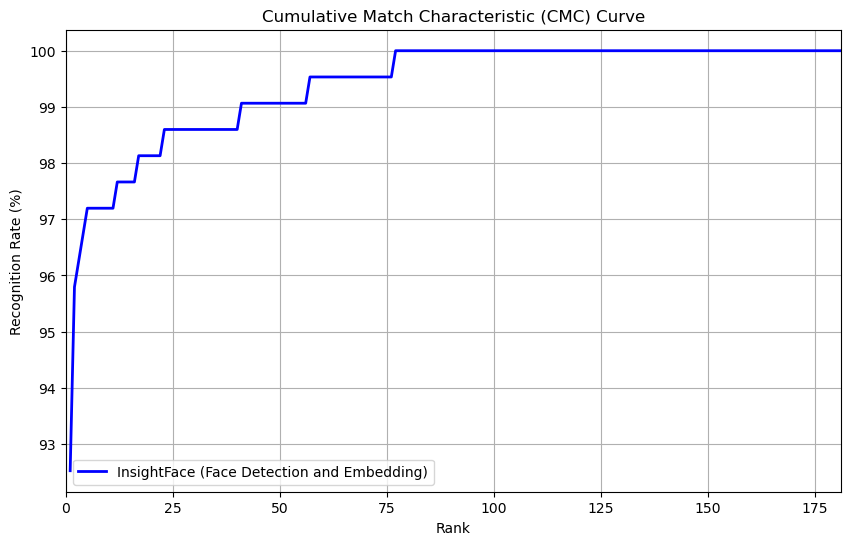

In [80]:
# Extract features for gallery and probe images using both models
gallery_features_insightface_face_detection_and_embedding = []
probe_features_insightface_face_detection_and_embedding = []

# Extract InsightFace features
for path in gallery_paths_test:
    faces = detect_faces_insightface(path)
    face_crop = crop_face(path, faces[0])
    embedding = compute_embedding(image=face_crop, model=model)
    embedding = normalize_features(embedding)
    gallery_features_insightface_face_detection_and_embedding.append(embedding)
    
for path in probe_paths_test:
    faces = detect_faces_insightface(path)
    face_crop = crop_face(path, faces[0])
    embedding = compute_embedding(image=face_crop, model=model)
    embedding = normalize_features(embedding)
    probe_features_insightface_face_detection_and_embedding.append(embedding)

# Convert to numpy arrays
gallery_features_insightface_face_detection_and_embedding = np.array(gallery_features_insightface_face_detection_and_embedding)
probe_features_insightface_face_detection_and_embedding = np.array(probe_features_insightface_face_detection_and_embedding)

# Calculate CMC curves
max_rank = len(gallery_features_insightface_face_detection_and_embedding)
cmc_insightface_face_detection_and_embedding = calculate_cmc(gallery_features_insightface_face_detection_and_embedding, gallery_ids_test, probe_features_insightface_face_detection_and_embedding, probe_ids_test, max_rank=max_rank)

print(f"rank1: {cmc_insightface_face_detection_and_embedding[0]}")
print(f"rank5: {cmc_insightface_face_detection_and_embedding[4]}")

# Plot CMC curves
plot_cmc(cmc_insightface_face_detection_and_embedding, label="InsightFace (Face Detection and Embedding)")
plt.show()


First probe example:
Probe ID: 138
Top 5 matched gallery IDs: [138 138 138 138 138]
Corresponding distances: [     2.5774       2.682      2.9597      4.0052      5.2883]
rank1: 0.9345794392523364
rank5: 0.9766355140186916


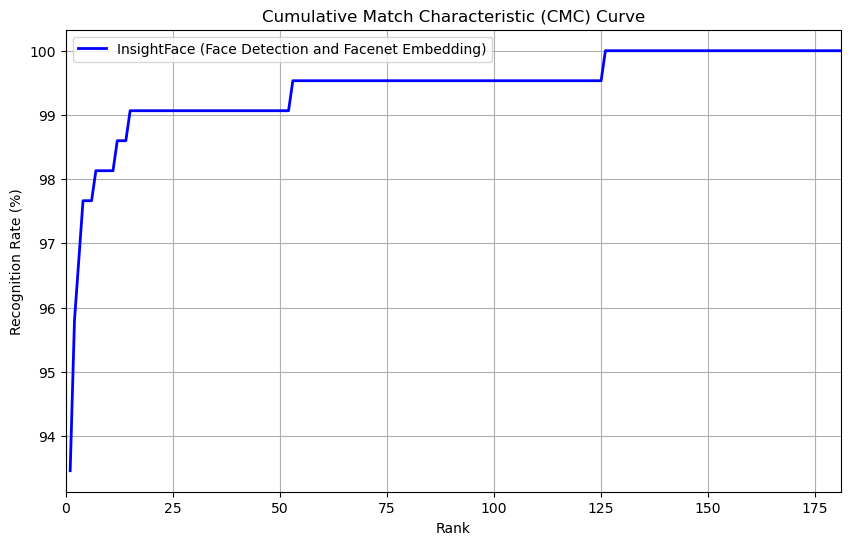

In [81]:
gallery_features_insightface_face_detection_facenet_embedding = []
probe_features_insightface_face_detection_facenet_embedding = []

# Extract InsightFace features
for path in gallery_paths_test:
    faces = detect_faces_insightface(path)
    face_crop = crop_face(path, faces[0])
    embedding = extract_facenet_embedding(image=face_crop)
    embedding = normalize_features(embedding)
    gallery_features_insightface_face_detection_facenet_embedding.append(embedding)
    
for path in probe_paths_test:
    faces = detect_faces_insightface(path)
    face_crop = crop_face(path, faces[0])
    embedding = extract_facenet_embedding(image=face_crop)
    embedding = normalize_features(embedding)
    probe_features_insightface_face_detection_facenet_embedding.append(embedding)

# Convert to numpy arrays
gallery_features_insightface_face_detection_facenet_embedding = np.array(gallery_features_insightface_face_detection_facenet_embedding)
probe_features_insightface_face_detection_facenet_embedding = np.array(probe_features_insightface_face_detection_facenet_embedding)

# Calculate CMC curves
max_rank = len(gallery_features_insightface_face_detection_facenet_embedding)
cmc_insightface_face_detection_facenet_embedding = calculate_cmc(gallery_features_insightface_face_detection_facenet_embedding, gallery_ids_test, probe_features_insightface_face_detection_facenet_embedding, probe_ids_test, max_rank=max_rank)

print(f"rank1: {cmc_insightface_face_detection_facenet_embedding[0]}")
print(f"rank5: {cmc_insightface_face_detection_facenet_embedding[4]}")

# Plot CMC curves
plot_cmc(cmc_insightface_face_detection_facenet_embedding, label="InsightFace (Face Detection and Facenet Embedding)")
plt.show()

dict_keys(['cmc_lbp', 'cmc_hog', 'cmc_dsift', 'cmc_lbp_vj', 'cmc_hog_vj', 'cmc_dsift_vj'])
170


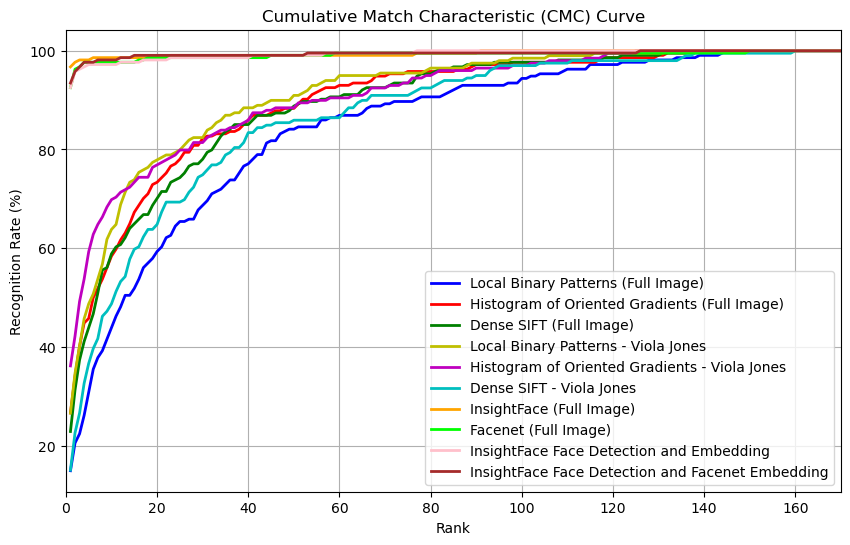

In [93]:

# plot the data from past assignemnt

with open("cmc_data_170.pkl", "rb") as f:
    cmc_data = pickle.load(f)

print(cmc_data.keys())
print(len(cmc_data[list(cmc_data.keys())[0]]))

#plot each cmc curve on same plot
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Rank')
plt.ylabel('Recognition Rate (%)')
plt.title("Cumulative Match Characteristic (CMC) Curve")
plt.xlim(0, 170)

colors = ['b-', 'r-', 'g-', 'y-', 'm-', 'c-', 'orange-', 'lime-', 'pink-', 'brown-']
for key, color in zip(cmc_data.keys(), colors):
    l = key[4:]

    if l == "lbp":
        l = "Local Binary Patterns (Full Image)"
    elif l == "hog":
        l = "Histogram of Oriented Gradients (Full Image)"
    elif l == "dsift":
        l = "Dense SIFT (Full Image)"
    elif l == "lbg_vj":
        l = "Local Binary Patterns - Viola Jones"
    elif l == "lbp_vj":
        l = "Local Binary Patterns - Viola Jones"
    elif l == "hog_vj":
        l = "Histogram of Oriented Gradients - Viola Jones"
    elif l == "dsift_vj":
        l = "Dense SIFT - Viola Jones"
    plot_cmc(cmc_data[key], label=l, color=color, new_figure=False)

plot_cmc(cmc_insightface_full_img, label="InsightFace (Full Image)", color="orange", new_figure=False)
plot_cmc(cmc_facenet_full_img, label="Facenet (Full Image)", color="lime", new_figure=False)
plot_cmc(cmc_insightface_face_detection_and_embedding, label="InsightFace Face Detection and Embedding", color="pink", new_figure=False)
plot_cmc(cmc_insightface_face_detection_facenet_embedding, label="InsightFace Face Detection and Facenet Embedding", color="brown", new_figure=False)

# Save as SVG (Vector format)
plt.savefig("cmc_plot.svg", format="svg")
plt.savefig("plot.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [83]:
# save all the cmc data to a new file and save ALL cmc curves
all_cmc_data = {
    "cmc_data": cmc_data,
    "cmc_insightface_full_img": cmc_insightface_full_img,
    "cmc_facenet_full_img": cmc_facenet_full_img,
    "cmc_insightface_face_detection_and_embedding": cmc_insightface_face_detection_and_embedding,
    "cmc_insightface_face_detection_facenet_embedding": cmc_insightface_face_detection_facenet_embedding
}

with open("all_cmc_data.pkl", "wb") as f:
    pickle.dump(all_cmc_data, f)
